# Intro to work with chant data

Cantus Index as big source - for CantusCorpus v1.0 also

Structure of data derived from the database:

![Chant cataloguing schema.](img/chant-cataloguing-schema.png)

For structure of Chant and Source records refer to the Development documentation.  
For gaining more knowledge about Gregorian chant data confront the Intro to chant in documentation.  
Intro to structure of Cantus Database data can bring also documentation of [CantusCorpus](https://github.com/DvorakovaA/CantusCorpus) dataset.

In [1]:
import pycantus
import pycantus.data as data

## Load data
Load the full CantusCorpus v1.0 as one of the pycantus available datasets.  
(If data files are not ready, pycantus will download them.)

In [62]:
# Load the full CantusCorpus v1.0 dataset
cantuscorpus = data.load_dataset('cantuscorpus_v1.0', load_editable=True, create_missing_sources=True)

print(f'Number of chants before filtering: {len(cantuscorpus.chants)}')

Loading chants and sources...
Creating missing sources...
0 missing sources created!
Data loaded!
Number of chants before filtering: 888010


Let's check how many chants exactly we got:

In [3]:
n_chants = len(cantuscorpus.chants)
print(f'Number of chants in CantusCorpus v1.0: {n_chants}')

Number of chants in CantusCorpus v1.0: 888010


And what information is available for each of the chants:

In [4]:
print('Data fields in a chant record:')
for field in cantuscorpus.chants[0].header().split(','):
    print(' ', field)

Data fields in a chant record:
  cantus_id
  incipit
  siglum
  srclink
  chantlink
  folio
  db
  sequence
  feast
  genre
  office
  position
  melody_id
  image
  mode
  full_text
  melody
  century


In [5]:
print('Data fields in a source record:')
for field in cantuscorpus.sources[0].header().split(','):
    print(' ', field)

Data fields in a source record:
  title
  siglum
  century
  provenance
  srclink
  numeric_century
  cursus


# Statistics
Here we would like to inspect our dataset a bit.

We know we have catalogued this huge amount of chants, but many of these will be copies of the same repertoire across many manuscripts. So, how many distinct chants do we have in the catalogued repertoire?

This can be done thanks to the essential Cantus ID mechanism. Instances of the same chant across different manuscripts have the same Cantus ID assigned.

In [6]:
all_cantus_ids = set(chant.cantus_id for chant in cantuscorpus.chants)
print(f'Number of distinct chants (by Cantus ID): {len(all_cantus_ids)}')

Number of distinct chants (by Cantus ID): 53282


So on average, we can expect to see each Cantus ID:

In [7]:
n_chants / len(all_cantus_ids)

16.666228745167224

But of course averages are not terribly informative. What we probably want to really know is the frequency profile of Cantus IDs: how many appear only once, how many appear twice, and how many are on the other hand of the spectrum, appearing tens or even hundreds of times.

In [8]:
def cantus_id_frequencies(corpus):
    cid_frequencies = {}
    for chant in corpus.chants:
        cid = chant.cantus_id
        # If this is the first time we see this cid, initialize its count to zero
        if cid not in cid_frequencies:
            cid_frequencies[cid] = 0
        # '+=' means 'add and modify original'. 
        # It's shorthand for cid_frequencies[cid] = cid_frequencies[cid] + 1
        cid_frequencies[cid] += 1 
    return cid_frequencies

In [9]:
cc_cid_frequencies = cantus_id_frequencies(cantuscorpus)

**Visualisation.**

Now we know how often each Cantus ID appeared in the dataset, but printing a dictionary of 31,000+ entries is also not helpful. But what we can do is visualise.

For this, the `matplotlib` library is the most widespread and best-documented for Python.

(Generally when you need to pick a library out of several choices that all support the features you require, go for the one that is most widely used. When you encounter some issue, the more users a library has, the more likely it is that someony has already had that issue and got it resolved, either through StackOverflow or some other publicly available forum.)

In [10]:
import matplotlib.pyplot as plt
# This is a magical shortcut for making sure the visualisatons will be plotted nicely directly in the notebook:
%matplotlib inline

Let's just plot the Cantus ID frequencies, sorted from highest to lowest.

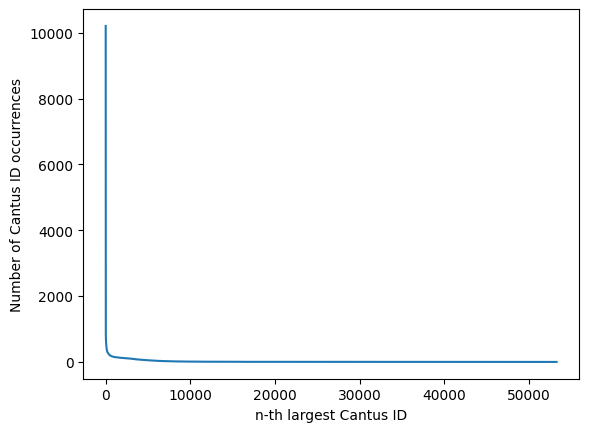

In [11]:
cid_frequencies_sorted = list(sorted(cc_cid_frequencies.values(), reverse=True))  # sorted() by default goes from lowest to highest

plt.plot(cid_frequencies_sorted)
plt.xlabel('n-th largest Cantus ID')   # Best practice: always label both axes.
plt.ylabel('Number of Cantus ID occurrences')
plt.show()

Ok, this is also not very helpful.  
The most frequent Cantus ID occurred more than 10000 times, which makes the rest of the plot rather uninformative.  
  
Let's see the highest-frequency values.

In [12]:
cid_and_frequency_pairs_sorted = list(
    sorted(cc_cid_frequencies.items(),    # The .items() function of a dictionary returns an iterator over all key-value pairs
           reverse=True,               # We still want to go from highest to lowest
           key=lambda kv: kv[1]        # ...so we have to sort by the *value* part of the (key, value) pair.
           )
    )                                  # Finally, we turn the whole thing into a regular list,
                                       # to not have to deal with some Python efficiency magic on sorted() and .items().

In [13]:
# Look at top 10 most frequent Cantus IDs
cid_and_frequency_pairs_sorted[:10]

[('909000', 10207),
 ('g01278', 1221),
 ('008097', 1184),
 ('g01260', 1154),
 ('008414', 1139),
 ('008081', 1090),
 ('001328', 1024),
 ('008201', 1007),
 ('509501', 972),
 ('g00116', 954)]

Ok, `909000` looks like a legitimate Cantus ID. What chant does it represent?

In [14]:
chants_with_909000 = [c for c in cantuscorpus.chants if c.cantus_id == '909000']

In [15]:
print(chants_with_909000[0])
print(chants_with_909000[0].full_text)

Gloria patri et filio et
  Cantus ID: 909000
  Genre: V
  Office: M
  Chantlink: https://cantusdatabase.org/chant/243163
  Feast: Dom. 1 Adventus
  Source: A-Gu 29
  Srclink: https://cantusdatabase.org/source/123610

Gloria patri et filio et spiritus sancto


In [16]:
print(chants_with_909000[2330])
print(chants_with_909000[2330].full_text)

Gloria patri et filio et spiritui 
  Cantus ID: 909000
  Genre: V
  Office: M
  Chantlink: https://cantusbohemiae.cz/chant/17713
  Feast: Margaritae
  Source: CZ-R (Rajhrad) R 17
  Srclink: https://cantusbohemiae.cz/source/2161

Gloria patri et filio et spiritui sancto


In [17]:
print(chants_with_909000[1000])
print(chants_with_909000[1000].full_text)


Gloria patri*
  Cantus ID: 909000
  Genre: V
  Office: V
  Chantlink: https://cantusdatabase.org/chant/547675
  Feast: Comm. unius Confessoris non Pontificis
  Source: A-Wn 1799**
  Srclink: https://cantusdatabase.org/source/123667

Gloria patri*


It's the **doxology**!

This is a great example of how the interaction between domain knowledge and computing skills is necessary. These are legitimate chant records: they have all the required information, they have a valid Cantus ID, they record what manuscript they come from, etc. So, those are not mistakes, in the sense in which the empty Cantus ID records were invalid.

What to do? Should we actually treat this as the most frequent Cantus ID? Should it participate in computing the average number of chants per Cantus ID? (Incidentally, the invalid records with no Cantus ID participated in that average as well.)

Here is where domain knowledge comes in. The doxology is the phrase:

_'Gloria Patri et Filii et Spiritui Sancto_

_sicut erat in principio et nunc et semper, et in saecula saeculorum. Amen.'_

which is added at the end of every psalm, and into many other chants, esp. those genres that use psalm verses as their texts. The doxology is not recorded too often, but because it occurs so many times in liturgy, when scribal practices of a certain time and place included recording the doxology as a separate unit (even if just in some contexts), then its frequency skyrockets.

So for the purpose of obtaining useful descriptive statistics, the doxology is not too helpful. Let's exclude it.

We can implement this via filtration exclude values option:

In [18]:
from pycantus.filtration import Filter
import copy

In [19]:
# Prepare a filter that excludes the doxology: Cantus ID 909000
exclude_doxology_filter = Filter('exclude_doxology')
exclude_doxology_filter.add_value_exclude('cantus_id', '909000')
cantuscorpus_no_dox = copy.copy(cantuscorpus)  # Make a copy of the original corpus, to not modify it
cantuscorpus_no_dox.apply_filter(exclude_doxology_filter)
print(f'Number of chants after filtering doxology out: {len(cantuscorpus.chants)}')

Number of chants after filtering doxology out: 888010


Now let's redo the statistics:

In [20]:
all_cantus_ids_no_dox = set(chant.cantus_id for chant in cantuscorpus_no_dox.chants)
print(f'Number of distinct chants (by Cantus ID): {len(all_cantus_ids_no_dox)}')

Number of distinct chants (by Cantus ID): 53281


In [21]:
len(cantuscorpus_no_dox.chants) / len(all_cantus_ids_no_dox)

16.47497231658565

In [22]:
cc_no_dox_frequencies = cantus_id_frequencies(cantuscorpus_no_dox)

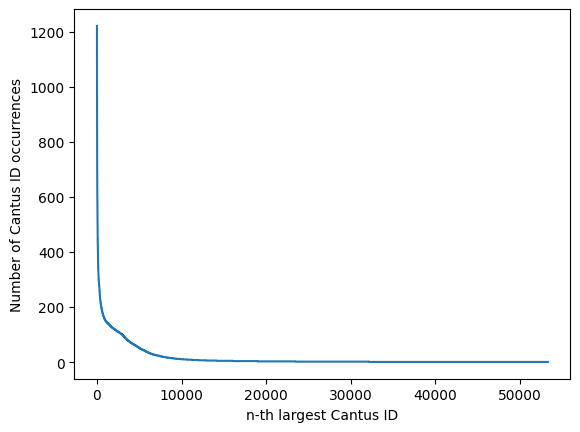

In [23]:
cc_no_dox_frequencies_sorted = list(sorted(cc_no_dox_frequencies.values(), reverse=True))  # sorted() by default goes from lowest to highest

plt.plot(cc_no_dox_frequencies_sorted)
plt.xlabel('n-th largest Cantus ID')   # Best practice: always label both axes.
plt.ylabel('Number of Cantus ID occurrences')
plt.show()

These are suddenly more reasonable numbers! We know that the CantusCorpus contains some hundred sources, and some very frequent chants can occur multiple times within a source, so having some very small number of chants that have frequencies like 800 or even 1200 is probably not a mistake or not something strange that would require excluding the Cantus ID.  
  
But we should certainly check again, just to be sure!
  
Let's re-compute the list of most frequent Cantus IDs and their frequencies:

In [24]:
cid_and_frequency_no_dox_pairs_sorted = list(
    sorted(cc_no_dox_frequencies.items(),    # The .items() function of a dictionary returns an iterator over all key-value pairs
           reverse=True,               # We still want to go from highest to lowest
           key=lambda kv: kv[1]        # ...so we have to sort by the *value* part of the (key, value) pair.
           )
    )                                  # Finally, we turn the whole thing into a regular list,
                                       # to not have to deal with some Python efficiency magic on sorted() and .items().

In [25]:
cid_and_frequency_no_dox_pairs_sorted[:10]

[('g01278', 1221),
 ('008097', 1184),
 ('g01260', 1154),
 ('008414', 1139),
 ('008081', 1090),
 ('001328', 1024),
 ('008201', 1007),
 ('509501', 972),
 ('g00116', 954),
 ('008014', 952)]

Ok, let's see what we got here now:

In [26]:
chants_with_g01278 = [c for c in cantuscorpus_no_dox.chants if c.cantus_id == 'g01260']

In [27]:
print(chants_with_g01278[0])
print(chants_with_g01278[180])
print(chants_with_g01278[432])

Gloria et honore *
  Cantus ID: g01260
  Genre: Of
  Office: MASS
  Chantlink: http://musmed.eu/chant/204540
  Feast: Adriani
  Source: A-A Cod. 786
  Srclink: http://musmed.eu/source/98938

Gloria et honore *
  Cantus ID: g01260
  Genre: Of
  Office: MASS
  Chantlink: http://musmed.eu/chant/217120
  Feast: None
  Source: CH-SGs Cod 0376
  Srclink: http://musmed.eu/source/14288

Gloria et honore*
  Cantus ID: g01260
  Genre: Of
  Office: MASS
  Chantlink: https://pemdatabase.eu/musical-item/74592
  Feast: Comm. unius Martyris
  Source: E-SAu (Salamanca) Universidad, Archivo y Biblioteca Ms 2637
  Srclink: https://pemdatabase.eu/source/48357



If we inspect Cantus Index, this looks like very common Offertory for all kinds of feasts.  
For us it means it is just very frequent chant, but not such "anomaly" as doxology, and so we want to keep it.

Let's look at another, this time CAO and Office, chant in the list: `008097`

In [28]:
chants_with_008097 = [c for c in cantuscorpus_no_dox.chants if c.cantus_id == '008097']


In [29]:
print(chants_with_008097[0])
print(chants_with_008097[180])
print(chants_with_008097[432])

In omnem terram*
  Cantus ID: 008097
  Genre: W
  Office: V2
  Chantlink: https://cantusdatabase.org/chant/245357
  Feast: Andreae
  Source: A-Gu 29
  Srclink: https://cantusdatabase.org/source/123610

In omnem terram*
  Cantus ID: 008097
  Genre: W
  Office: M
  Chantlink: https://cantusbohemiae.cz/chant/38748
  Feast: Matthaei
  Source: CZ-Pn (Praha) XII A 21
  Srclink: https://cantusbohemiae.cz/source/37034

In omnem terram*
  Cantus ID: 008097
  Genre: W
  Office: V2
  Chantlink: http://musmed.eu/chant/35775
  Feast: Conversio Pauli
  Source: F-CH Ms 0050
  Srclink: http://musmed.eu/source/23756



If we check this with Cantus Index (looking at concordances of `008097`), it turns out that this is a versicle (genre: `W`) for the Divine Office when there is a feast scheduled in the liturgical calendar that has something to do with an apostle (Peter, John, Mark, Thomas, etc.). No wonder that it is very frequent. But this is no anomaly. It should stay in the database.

Let's plot the result once more to remind us what the distribution of Cantus IDs is like:

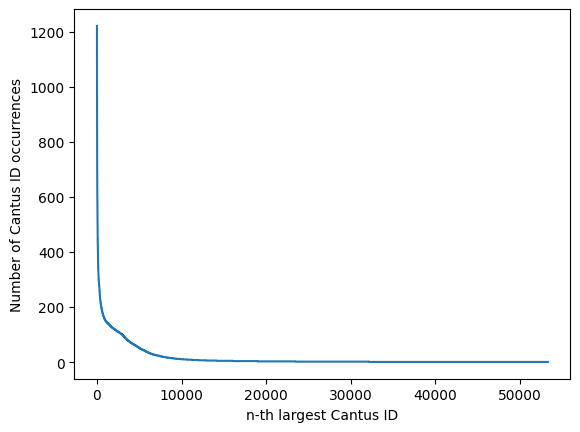

In [30]:
plt.plot(cc_no_dox_frequencies_sorted)
plt.xlabel('n-th largest Cantus ID')   # Best practice: always label both axes.
plt.ylabel('Number of Cantus ID occurrences')
plt.show()

Finally we might want to have a look at sizes of the source databases:  
(Although the output is not aligned well...)

In [31]:
distribution_by_db = {}
for db in set(c.db for c in cantuscorpus.chants):
    distribution_by_db[db] = len([c for c in cantuscorpus.chants if c.db == db])

# Sort the items by count, highest first
distribution_by_db_sorted = list(
    sorted(distribution_by_db.items(),
           reverse=True,
           key=lambda kv: kv[1]
           )
    )

print('Distribution of chants by database:')
for db, count in distribution_by_db_sorted:
    print(f' {db}:\t {count}')

Distribution of chants by database:
 CD:	 429982
 MMMO:	 212231
 SEMM:	 104678
 FCB:	 36103
 PEM:	 32738
 CPL:	 30433
 CSK:	 22539
 HCD:	 11278
 HYM:	 5290
 A4M:	 2738


And it come with not a big surprise that the oldest of them, Cantus Database, is by a big difference also the biggest.

# Description of selected fields and their potential problems

## Sources
There are many possible divisions of liturgical book such as Temporale and Sanctorale, or Antiphoners (and notated Breviaries) and Graduals (and notated Missals), winter or summer book etc.  
But since information about sources was collected directly from individual database websites, the available information is limited by the shared availability of individual data fields.  


### Size
Looking at number of chants in manuscript (source) and thinking "this is little" can mean few different things:
- fragment (sometimes fragments of one book are even indexed separately)
- incomplete indexation of manuscript (somebody is not finished with indexation of that piece)
  
Usually we do not want to work with fragments, but for some applications it can be enough that e.g. full office for some feast is present. That leads to different sequence of operations on Corpus:  
1. We want to avoid fragments

In [32]:
print(f'Number of all sources in CantusCorpus v1.0: {len(cantuscorpus.sources)}')
my_corpus1 = copy.copy(cantuscorpus)
my_corpus1.drop_small_sources_data(min_chants=100) # avoid fragments
print(f'Number of sources in my_corpus1 after dropping fragments (<100 chants): {len(my_corpus1.sources)}')
my_filter = Filter('my_filter')
my_filter.add_value_include('feast', 'Silvestri') # focus on Adalberti feast
my_corpus1.apply_filter(my_filter)
my_corpus1.drop_empty_sources()

print(f'Number of chants in my_corpus1: {len(my_corpus1.chants)}')
print(f'Number of sources in my_corpus1: {len(my_corpus1.sources)}')

Number of all sources in CantusCorpus v1.0: 2278
Number of sources in my_corpus1 after dropping fragments (<100 chants): 510
Number of chants in my_corpus1: 1318
Number of sources in my_corpus1: 169



2. We want to keep as many Silvestri chants as possible

In [33]:
my_corpus2 = copy.copy(cantuscorpus)
my_filter = Filter('my_filter')
my_filter.add_value_include('feast', 'Silvestri')
my_corpus2.apply_filter(my_filter)
my_corpus2.drop_empty_sources()
print(f'Number of sources in my_corpus2 after filtrating Silvestri and dropping empty sources: {len(my_corpus2.sources)}')
my_corpus2.drop_small_sources_data(min_chants=1)

print(f'Number of chants in my_corpus2: {len(my_corpus2.chants)}')
print(f'Number of sources in my_corpus2: {len(my_corpus2.sources)}')

Number of sources in my_corpus2 after filtrating Silvestri and dropping empty sources: 172
Number of chants in my_corpus2: 1338
Number of sources in my_corpus2: 172


In [34]:
common_chants = len(set(chant.chantlink for chant in my_corpus1.chants).intersection(set(chant.chantlink for chant in my_corpus2.chants)))
print(f'Number of common chants in my_corpus1 and my_corpus2: {common_chants}')

Number of common chants in my_corpus1 and my_corpus2: 1318


Which is the number of chants in `my_corpus1` ...

### Place of Origin
By place of origin we mean value of field `provenance`.  
  
This field has no standardization even within some databases, and so between . And by lack of standardization not only different spelling or language (`Londres`, `St. Martial` vs `St-Martial`) is meant but also different granularity (`Germany` vs `Barcelona` vs `Monasterio de Santa Cruz de la Serós (Huesca)`) or type of value (`Franciscan`).
  
So working with place of origin can be very tricky.  
  
Part of this work was underwent in development of ChantMapper tool ([github](https://github.com/DvorakovaA/ChantMapper/), see `geography_data.csv` and `provenance_ids.csv` data files), where coordinates were assigned to part of the values from the provenance field as well as some same places were unified with `provenance_id` identifier.

To illustrate this on our data let's look at sources coming from Czech database FCB:

In [35]:
czech_filter = Filter('czech_filter')
czech_filter.add_value_include('db', 'FCB') # FCB = Fontes Cantus Bohemiae
cantuscorpus_czech = copy.copy(cantuscorpus)
cantuscorpus_czech.apply_filter(czech_filter)
cantuscorpus_czech.drop_empty_sources()
print(f'Number of chants in cantuscorpus_czech: {len(cantuscorpus_czech.chants)}')
print(f'Number of sources in cantuscorpus_czech: {len(cantuscorpus_czech.sources)}')

Number of chants in cantuscorpus_czech: 36103
Number of sources in cantuscorpus_czech: 30


In [36]:
czech_provenances = set(source.provenance for source in cantuscorpus_czech.sources if source.provenance is not None)
print(f'Number of distinct provenances in cantuscorpus_czech: {len(czech_provenances)}')
print('Provenances:')
for prov in sorted(list(czech_provenances)):
    print(' ', prov)

Number of distinct provenances in cantuscorpus_czech: 13
Provenances:
  Bohemia
  Bohemia (Prague?)
  Břevnov monastery
  Kolín
  Moravia
  Pilsen
  Prague
  Prague (?)
  Praha, klášter sv. Jiří
  Rajhrad
  St George's Convent in Prague
  St George's Convent in Prague (?)
  St George's convent in Prague


Which is as we hope illustrative example on how one institution can be described with three (four) different strings even within one database.

### Institution of Origin
By this is meant field `cursus` with granularity of institution type:  
`Monastic` (used in monastery, written for monastery)   
or  
`Secular` (for church, cathedral etc.)

Unfortunately not always indexed and so incomplete field.  
Plus also values `cathedral` or `Romanum` (technically meaning the same as Secular) can be present.

In [37]:
cursus_values = set(source.cursus for source in cantuscorpus.sources if source.cursus is not None)
print(f'Number of distinct cursus values in cantuscorpus: {len(cursus_values)}')
print('Cursus values:')
for cur in sorted(list(cursus_values)):
    print(' ', cur)

Number of distinct cursus values in cantuscorpus: 5
Cursus values:
  Monastic
  Romanum
  Secular
  cathedral
  unknown


Now let's inspect how frequent it is, that cursus value is present for source:

In [79]:
print(f'Number of sources in CantusCorpus v1.0: {len(cantuscorpus.sources)}')

distribution_by_cursus = {}
for cur in cursus_values:
    distribution_by_cursus[cur] = len([s for s in cantuscorpus.sources if s.cursus == cur])

total_values = sum(distribution_by_cursus.values())
print('Specified cursus values distribution:')
for cur, count in sorted(distribution_by_cursus.items(), key=lambda kv: kv[1], reverse=True):
    print(f' {cur}:\t {count}')

print('Sources with unspecified cursus:', len(cantuscorpus.sources) - total_values)


Number of sources in CantusCorpus v1.0: 2278
Specified cursus values distribution:
 Secular:	 196
 Monastic:	 86
 cathedral:	 49
 unknown:	 35
 Romanum:	 14
Sources with unspecified cursus: 1898


Well, unfortunately not very frequent.

**What differences does this bring?**  
Well, in Divine Office the structure of some services (offices) may vary depending on whether they are used in monasteries or in churches, e.g. Matins are "richer" in monastic cursus - having more responsories and antiphons. So comparing sources of different origin can show differences that are not really a discovery, but just reflects intended usage.

In [38]:
# CZ-Pn (Praha) XII A 21 - Secular cursus https://cantusbohemiae.cz/source/37034
XII_A_21_filter = Filter('XII_A_21_filter')
XII_A_21_filter.add_value_include('srclink', 'https://cantusbohemiae.cz/source/37034')
XII_A_21_filter.add_value_include('feast', 'Visitatio Mariae')
XII_A_21_filter.add_value_include('office', 'M')
XII_A_21 = copy.copy(cantuscorpus)
XII_A_21.apply_filter(XII_A_21_filter)
print(f'Number of chants in XII_A_21 for Matins of Visitatio Marie: {len(XII_A_21.chants)}')

Number of chants in XII_A_21 for Matins of Visitatio Marie: 31


In [39]:
# CZ-Pu (Praha) VI G 3a - Monastic cursus https://cantusbohemiae.cz/source/9147
VI_G_3a_filter = Filter('VI_G_3a_filter')
VI_G_3a_filter.add_value_include('srclink', 'https://cantusbohemiae.cz/source/9147')
VI_G_3a_filter.add_value_include('feast', 'Visitatio Mariae')
VI_G_3a_filter.add_value_include('office', 'M')
VI_G_3a = copy.copy(cantuscorpus)
VI_G_3a.apply_filter(VI_G_3a_filter)
print(f'Number of chants in VI_G_3a for matins in Visitatio Mariae: {len(VI_G_3a.chants)}')

Number of chants in VI_G_3a for matins in Visitatio Mariae: 40


In [40]:
print('Antiphons position in Matins for Visitatio Mariae:')
antiphons_positions_secular = [chant.position for chant in XII_A_21.chants if chant.genre == 'A'] # also filter could be used here
antiphons_positions_monastic = [chant.position for chant in VI_G_3a.chants if chant.genre == 'A'] # also filter could be used here
print('XII A 21:', sorted(antiphons_positions_secular))
print('VI G 3a:', sorted(antiphons_positions_monastic))


Antiphons position in Matins for Visitatio Mariae:
XII A 21: ['1.1', '1.2', '1.3', '2.1', '2.2', '2.3', '3.1', '3.2', '3.3']
VI G 3a: ['1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '2.1', '2.2', '2.3', '2.4', '2.5', '2.6', '3.']


On the difference in total number of chants for Matins in the two sources (9), as well as on different used positions for antiphons of Matins the difference in structure between Secular and Monastic Matins is illustrated (the `3.` value in position stands for *antiphone super psalmos* that is sung around all psalms of section, here in the third Nocturn).  
(Rest of the difference is caused by differences in responsories and presence/absence of hymn and some versicles.)

### Century and Numeric Century
Field `century` contains the string from original database, that can be in many ways non-standardized. It is good for detailed research, potentially printing out results or for checking assumptions "by eye".  
  
Field `numeric_century` is an integer representing the value of century field, that was automatically assigned during data load. It is good for search and comparisons.

In [41]:
centuries = set(source.century for source in cantuscorpus.sources if source.century is not None)
print(f'Number of distinct centuries in cantuscorpus: {len(centuries)}')
print('Few centuries examples:')
for cent in list(centuries)[:10]:
    print(' ', cent)

Number of distinct centuries in cantuscorpus: 131
Few centuries examples:
  late 16th - early 17th cent.
  1800
  14th century (1375-1400)
  12th century (1175-1200)
  15th century, 16th century
  14th - 15th cent.
  late 16th century
  14th century
  11th - 12th cent.
  c. 1450-1500


In [42]:
num_centuries = set(source.numeric_century for source in cantuscorpus.sources if source.numeric_century is not None)
print(f'Number of distinct numeric_centuries in cantuscorpus: {len(num_centuries)}')
print('Few numeric centuries examples:')
for num_cent in list(num_centuries)[:5]:
    print(' ', num_cent)

Number of distinct numeric_centuries in cantuscorpus: 13
Few numeric centuries examples:
  8
  9
  10
  11
  12


In [43]:
print('Few examples of century and numeric_century fields:')
print(f' numeric_century = "{cantuscorpus.sources[40].numeric_century}"  | century = {cantuscorpus.sources[40].century}')
print(f' numeric_century = "{cantuscorpus.sources[349].numeric_century}" | century = {cantuscorpus.sources[349].century}')
print(f' numeric_century = "{cantuscorpus.sources[350].numeric_century}" | century = {cantuscorpus.sources[350].century}')
print(f' numeric_century = "{cantuscorpus.sources[81].numeric_century}" | century = {cantuscorpus.sources[81].century}')

Few examples of century and numeric_century fields:
 numeric_century = "9"  | century = 9th century
 numeric_century = "12" | century = c. 1100
 numeric_century = "13" | century = 13th cent.
 numeric_century = "15" | century = 15th century (2nd half)


## Chants
Chants can be divided into some groups, which can help us a lot in research.  
The highest-level thing to address is that nwe have two non-overlapping liturgies: **the Mass** and **the Divine Office**. 
These are in fact overwhelmingly written in different types of medieval manuscripts -- Antiphoners (and notated Breviaries) for the Office, and Graduals (and notated Missals) for the Mass. This material difference illustrates the distinction between these two elementary types of Latin liturgy.

We should therefore probably analyse chants for the Mass and for the Office separately.  
There are two ways to distinguish which liturgy a chant belongs to in Cantus: the `office`, and the `genre`. But, the `office` has had a somewhat inconsistent cataloguing history, while the genres are applied much more rigorously in Cantus, and each genre of chant by definition belongs to only one of these liturgies.  
Additionally, each genre corresponds to a particular liturgical position and thus a purpose that the practitioners had for the given group of chants, and genres have proven very useful in identifying e.g. use -- focusing on *alleluias* rather than *offertories*, for instance, is much more fruitful in determining what ecclesiastical context a manuscript might be coming from.

### Genres
List of genre abbreviations is available in Cantus Index [here](https://cantusindex.org/genre) with rite (`Franco-Roman` or `Hispanic`) listed.  
  
Here are listed core genres for Office and for Mass:  

In [44]:
GENRES_MASS_PROPERS = ['In', 'InV', 'Gr', 'GrV', 'Al', 'AlV', 'Of', 'OfV', 'Cm', 'CmV', 'Tc', 'TcV']
GENRES_OFFICE = ['A', 'R', 'V', 'W', 'I']

When working with Gregorian chant these might be good genre to stick to as a "safe option".   
For some purposes even considering only antiphons (`A`) and responsories (`R`) can be a informative yet comprehensible subset of Divine Office data.  

### Offices (Services)
Here Cantus Index does not provide any list as there are also some standardization issues... but for some overview [Service Abbreviations list](https://cantusdatabase.org/services/) from Cantus Database can be good reference. That holds expect for Mass where many other databases uses the value `MASS` instead of `MI`.  
Service `E` for "in evangelio" can be substituted with annotating the antiphon (e.g. in Magnificat) as part of given service (e.g. `V`).  
  
As a "safe to work with" as well as reasonably informative we can recommend these:

In [45]:
OFFICE_BASIC = ['V', 'M', 'L', 'V2']

### Feasts
Generally can be divided based on being in Sanctorale (generally Saints) or Temporale (generally said feasts connected to Jesus Christ). Even sources are sometimes divided like that - you cannot expect repertoire for First Sunday of Advent from a Sanctorale maniscript.  

Local feasts can be tricky as they appearance as well as repertoire are influenced by local things, donators, etc.  
  
There also lies another standardization issue which can be in spelling (e.g. `Ludmillae` vs `Ludmilae`) or more generally structure of the names (e.g. `Agathae, infra oct.` vs `Agathae, 8`).  
  
This issue can be resolved with `feastcode` value, but that is not part of the [Cantus Index JSON API](https://github.com/dact-chant/cantus-index/blob/main/README.md) and also not all feasts have `feastcode` assigned.  
  
Besides Cantus Index [Feasts list](https://cantusindex.org/feasts) there is also Liturgical Feasts and Rites ([LFRI](https://lfri.pemdatabase.eu/home)) initiative around feast namings etc.

In [48]:
print(f'Number of distinct feast names in CantusCorpus v1.0:', len(set([ch.feast for ch in cantuscorpus.chants])))

Number of distinct feast names in CantusCorpus v1.0: 2401


A good subset of repertoire bigger then one day feast can be some well defined "group of days", e.g.:
- Marian feast days
    - but there is a problem of their "different age" (for instance Nativity of Mary is much older feast then Visitation of Mary)
- Christmas (possibly with Advent)
    - we have to defined well when this period starts and ends in our assumptions
- Easter
    - same thing as with Christmas... do we want repertoire from Lent? Whole Holy Week? Only Friday to Sunday?
- Apostles
    - here we have to consider whether we are interested also in "Common" repertoire (here especially *Comm. Apostolorum*)
- Virgins
    - only virgins? or also virgin martyrs? again do we want *Comm. plurimorum Virginum* ?
- Maybe something like "young feasts" ? 
    - Corpus Christi, Visitation of Mary ...
- ...
- Whatever else can be useful for your research question

### Cantus IDs
We can observe few patterns on Cantus IDs structure.  
  
**CAO**  
Chants from volumes of *Corpus Antiphonalium Officii* by René-Jean Hesbert have 4-digit numbers assigned by Hesbert. 
The prefix `00` precedes all 4-digit CAO numbers making each "CAO"-sourced Cantus ID 6 digits (plus applicable letter-suffixes), thus preserving Hesbert’s assignments but allowing for future growth of the database.

**Not CAO**  
The six-number format and the `g#####`s, `a#####`s, and `h#####`s (plus suffixes) now identify each chant in Cantus Index and the Cantus Database.
The prefix designations `a`, `g` and `h` were introduced which generally identify Office chants (`a`), Mass chants (`g`), and Old-Hispanic chants (`h`), although there is some crossover.

**Variants**  
If the some chant is quite similar to another chant of the same genre, the new text will receive the Cantus ID of the similar chant plus a “variant” `.1`, `.2`, `.3`, etc. suffix.  
  
(For full history description see [ID Numbers: A History and Explanation](https://cantusdatabase.org/about/id-numbers/).)


In [49]:
print(f'Number of CAO cantus IDs in CantusCorpus v1.0:', len(set(ch.cantus_id for ch in cantuscorpus.chants if ch.cantus_id.startswith('00'))))

Number of CAO cantus IDs in CantusCorpus v1.0: 13256


(Distribution of Cantus IDs was plotted in the Statistics part of this tutorial notebook.)

## Melody
Melodies are encoded using volpiano, which is both a encoding standard and a font to render itself (for more info and description look into [Volpiano Protocols](https://cantusdatabase.org/static/documents/2.%20Volpiano%20Protocols.pdf) from Cantus Database).  
Because it records exact pitches it is not applicable for earlier staffless neumes (but these data are not in CantusCorpus).  
  
Melody encoded as a volpiano string:  
`1---fE--de--fdc---dc---d--ef--g--de--e---dh--hG--g---hk--hg-gfe---e--g---gh--hgfe--de--e77---efg--fe--d---g--f---gh--gfe--dE---e--e---4---h--g--h--k--g--e---3`

This volpiano string rendered in the volpiano font:
![Volpiano renderd in the font.](img/volpiano.png)

For work with melodies PyCantus implement few convenience methods so you do not have to as well as so you do not shoot your self into foot as people before you did :-)

First of all we want to work with melody objects of `Corpus`:

In [63]:
melodies = copy.copy(cantuscorpus.melody_objects)

Before working with melodies we definitely want to clean those volpiano strings otherwise we would face various troubles:
- Hyphens
    - Hyphens indicate syllable and word boundaries
    - We do not really care if the annotator used two or three hyphens between two notes on our level (and the practice is even not really uniform...)
    - So we want to throw all hyphens from the string away
- Different conventions around numbers used in the font
    - Numbers besides the first which is dedicated to clef (1 means treble clef) can mean different things, for example different kinds of barlines or line (or page) breaks... 
    - Again we want to throw them away as a noise for us
- Dealing with *b flat* (and possible flats in general)
    - b flat can appear in chant melodies and can be coded in at least 3 ways: 
        - `y` for low b flat -> meaning we have `yb` in the string
        - `i` for central b flat -> meaning we have `ij` in the string
        - `z` for high b flat -> meaning we have `zq` in the string
    - Overall we would usually like to avoid this 'two characters <-> one pitch' situation and so we would keep only the "flat letter", meaning `yb` in the volpiano string is reduced to `y`
- Phenomenon of liquescents (= written in capital letters)
    - These are the little notes in rendered font above
    - That is a noise again as it influences pronunciation which is not what we are interested in and again the annotation practice is not uniform
    - We want to "normalize" them to look like standard notes (no capitalization)
- Differentia
    - Antiphons can end with differentia - "evovae" text is usually written under this part of melody - and it helps with mode classification, so we typically want to discard it
    - If differentia is present and annotated the antiphon should end with a double barline (volpiano: `4`) and
    then the differentia should end with a single barline (volpiano: `3`), which is how our function tries to find it

So we want to go through all these steps:

In [51]:
from pycantus.volpiano import utils

In [65]:
# 1. Discard differentia
for mel in melodies:
    mel.volpiano = utils.discard_differentia(mel.volpiano)

print(f'Original volpiano:\n    {melodies[0].raw_volpiano}')
print(f'Volpiano with discarded differentia:\n    {melodies[0].volpiano}')

Original volpiano:
    1---fE--de--fdc---dc---d--ef--g--de--e---dh--hG--g---hk--hg-gfe---e--g---gh--hgfe--de--e77---efg--fe--d---g--f---gh--gfe--dE---e--e---4---h--g--h--k--g--e---3
Volpiano with discarded differentia:
    1---fE--de--fdc---dc---d--ef--g--de--e---dh--hG--g---hk--hg-gfe---e--g---gh--hgfe--de--e77---efg--fe--d---g--f---gh--gfe--dE---e--e---3


In [67]:
# 2. Normalize liquescents
for mel in melodies:
    mel.volpiano = utils.normalize_liquescents(mel.volpiano)

print(f'Original volpiano:\n    {melodies[0].raw_volpiano}')
print(f'Volpiano with normalized liquescents and discarded differentia:\n    {melodies[0].volpiano}')

Original volpiano:
    1---fE--de--fdc---dc---d--ef--g--de--e---dh--hG--g---hk--hg-gfe---e--g---gh--hgfe--de--e77---efg--fe--d---g--f---gh--gfe--dE---e--e---4---h--g--h--k--g--e---3
Volpiano with normalized liquescents and discarded differentia:
    1---fe--de--fdc---dc---d--ef--g--de--e---dh--hg--g---hk--hg-gfe---e--g---gh--hgfe--de--e77---efg--fe--d---g--f---gh--gfe--de---e--e---3


In [ ]:
# 3. Clean volpiano string
#   remove clefs
#   remove bars and other numbers
#   discard boundaries (hyphens)
for mel in melodies:
    mel.volpiano = utils.clean_volpiano(mel.volpiano, allowed_chars=None, keep_boundaries=False,
                                        neume_boundary=' ', syllable_boundary=' ', word_boundary=' ',
                                        keep_bars=False, allowed_bars='345', bar='|')

print(f'Original volpiano:\n    {melodies[0].raw_volpiano}')
print(f'Cleaned volpiano with discarded differentia and normalized liquescents:\n    {melodies[0].volpiano}')

Original volpiano:
    1---fE--de--fdc---dc---d--ef--g--de--e---dh--hG--g---hk--hg-gfe---e--g---gh--hgfe--de--e77---efg--fe--d---g--f---gh--gfe--dE---e--e---4---h--g--h--k--g--e---3
Cleaned volpiano with discarded differentia and normalized liquescents:
    fedefdcdcdefgdeedhhgghkhggfeegghhgfedeeefgfedgfghgfedeee


(Do not get confused with `allowed_bars` not being in the result - we have `keep_bars` set to `False`.)  
  
This parametrization is `clean_volpiano` default, we can call the function like this:
```
mel.volpiano = utils.clean_volpiano(mel.volpiano)
```
with same output.

**There is even a function wrapping them all into one call:**

In [73]:
cantuscorpus_melodies = copy.copy(cantuscorpus)
for melody in cantuscorpus_melodies.melody_objects:
    melody.normalize_volpiano()

print(f'Original volpiano:\n    {cantuscorpus_melodies.melody_objects[2].raw_volpiano}')
print(f'Normalized volpiano:\n    {cantuscorpus_melodies.melody_objects[2].volpiano}')

Original volpiano:
    1---hk-kj---kh--jh--gh--h---j---h---h--jk--hj---hh--g---h--eh--hj--h--h---j--k--lml-mnm---m---l--k--kj---hk--kj--g7---hk--k---kJ---h--jH--gh---hge---h--g--h---kj--g---jk--h---4---k--k--k--j--g--h---3
Normalized volpiano:
    hkkjkhjhghhjhhjkhjhhghehhjhhjklmlmnmmlkkjhkkjghkkkjhjhghhgehghkjgjkh


Finally we usually do not want to work with only notated incipits (only beginnings of chants) or somehow not **complete chants** (melodies) in research and so we want to drop these incomplete records.  

Conditions for being a complete chant:
- Has a melody
- The melody's volpiano is a valid string containing notes
- Has full text
- The full text is not identical to the incipit
- The volpiano starts with '1' (indicating G clef)
- The volpiano does not contain '2' (indicating F clef)
- The volpiano does not contain '6------6' (indicating missing pitches)
- The volpiano contains only valid characters
- The volpiano contains at least one word boundary ('---')
  
For that PyCantus offers a simple function call:

In [74]:
print(f'Number of all melodies in CantusCorpus v1.0: {len(cantuscorpus_melodies.melody_objects)}')
cantuscorpus_melodies.drop_incomplete_chants()
print(f'Number of melodies after dropping incomplete chants: {len(cantuscorpus_melodies.melody_objects)}')

Number of all melodies in CantusCorpus v1.0: 60588
Number of melodies after dropping incomplete chants: 36038


## Known Problems and Troubles
Refer to *Harmonization issues* document in CantusCorpus v1.0 that describes some known troubles of individual data fields. Part of that was already discussed in previous cells.

Overall we can say that the "troubleshooter" is mainly inconsistent practice of annotations.  
That means two things:
- Annotating something differently (e.g. position of responsories in Matins: *9* vs *3.3*)
- Not annotating something (typical for sources fields, overview is provided in CantusCorpus v1.0 README)

Also there are differences between sources from different times, specifically "older", "middle mess" and "younger" manuscripts where the "mess" is approximately 1250-1520 (meaning 13th and 14th century) ending with Council of Trent that decided to drastically limit permissible local liturgical specifics.